<a href="https://colab.research.google.com/github/staerkjoe/QuantRisk_Colab/blob/main/TicketCancellation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [125]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pkdarabi/classification-of-travel-purpose")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'classification-of-travel-purpose' dataset.
Path to dataset files: /kaggle/input/classification-of-travel-purpose


Link to dataset:
https://www.kaggle.com/datasets/pkdarabi/classification-of-travel-purpose

In [126]:
!pip install unidecode

In [127]:
import tensorflow as tf
import tf_keras as keras
import pandas as pd
# note: tensorflow 2.17 onwards uses tf.keras 3.0 internally,
# which seem to be still bugged and inconsistent.
# We therefore use tf_keras in according to tensorflow version.

import numpy as np
import os
import time
from unidecode import unidecode

In [128]:
for file in os.listdir(path):
    print(file)

train_data.csv


In [129]:
df = pd.read_csv(os.path.join(path, "train_data.csv"))

In [130]:
# drop columns that are unnecessary/not helpful for prediction

# List of columns to drop
drop_cols = [
    'BillID',               # Unique identifier
    'TicketID',             # Unique identifier
    'UserID',               # Sparse and semi-unique
    'BuyerMobile',          # Personal identifier
    'NationalCode',         # Personal identifier
    'HashPassportNumber_p', # Sparse and hashed
    'HashEmail',            # Sparse and hashed
    'CancelTime',           # Leaks target label
    'VehicleType'
]

# Drop columns from DataFrame
df = df.drop(columns=drop_cols)

# Optional: Confirm result
print("Remaining columns:", df.columns.tolist())




Remaining columns: ['Created', 'DepartureTime', 'ReserveStatus', 'Male', 'Price', 'CouponDiscount', 'From', 'To', 'Domestic', 'VehicleClass', 'TripReason', 'Vehicle', 'Cancel']


In [131]:
# Drop Nulla values for From and TO
df = df.dropna(subset=['From', 'To'])

# Combine 'From' and 'To' columns to create a list of all cities
all_cities = df['From'].tolist() + df['To'].tolist()

# Create a set of unique cities and convert it back to a list
unique_cities = list(set(all_cities))

# print(unique_cities)

# Mapping erstellen
city_mapping = {city: unidecode(city) for city in unique_cities}

'''
# Ausgabe als Dictionary
print("city_mapping = {")
for k, v in city_mapping.items():
    print(f"    '{k}': '{v}',")
print("}")
'''

'\n# Ausgabe als Dictionary\nprint("city_mapping = {")\nfor k, v in city_mapping.items():\n    print(f"    \'{k}\': \'{v}\',")\nprint("}")\n'

In [132]:
def normalize_city_name(name):
    if pd.isna(name):
        return None
    return (
        str(name)
        .strip()
        .replace('\u200c', '')  # remove zero-width non-joiner
        .replace(' (', '(')
        .replace(')', ')')
        .replace('‌', '')       # remove zero-width joiner
    )

def safe_unidecode(value):
    if pd.isna(value):
        return ""
    return unidecode(str(value))

df['From'] = df['From'].apply(normalize_city_name).map(city_mapping).apply(safe_unidecode)
df['To'] = df['To'].apply(normalize_city_name).map(city_mapping).apply(safe_unidecode)

df['FromMapped'] = df['From'].isin(city_mapping.values())
df['ToMapped'] = df['To'].isin(city_mapping.values())

# keep only rows where both 'From' and 'To' were mapped
df = df[df["FromMapped"] & df["ToMapped"]].copy()
# drop mapping flags
df.drop(columns=["FromMapped", "ToMapped"], inplace=True)

In [133]:
df['Price'].describe()

,Price
count,9.167200e+04
mean,3.333467e+06
std,7.696764e+06
min,-1.514000e+06
25%,1.025000e+06
50%,1.680000e+06
75%,3.150000e+06
max,3.837646e+08


In [134]:
q25 = df['Price'].quantile(0.25)
q75 = df['Price'].quantile(0.75)

df = df[(df['Price'] >= q25) & (df['Price'] <= q75)].copy()



In [135]:
# Columns Transformations

# Date FOrmat
df[['Created', 'DepartureTime']] = df[['Created', 'DepartureTime']].apply(pd.to_datetime)

# Price to €
exchange_rate = 0.00002027  # 1 IRR = 0.00002027 EUR
df['Price'] = (df['Price'] * exchange_rate).round(2)
df['CouponDiscount'] = (df['CouponDiscount'] * exchange_rate).round(2)


In [136]:
# Fearure Engineering
df['LeadTime'] = (df['DepartureTime'] - df['Created']).dt.total_seconds()
df['IsWeekend'] = (df['DepartureTime'].dt.weekday >= 5).astype(int)
df['DiscountRatio'] = np.where(df['Price'] > 0, df['CouponDiscount'] / df['Price'], 0)
df['BookingMonth'] = df['Created'].dt.month
df['DepartureMonth'] = df['DepartureTime'].dt.month
df['BookingWeekday'] = df['Created'].dt.weekday
df['DepartureWeekday'] = df['DepartureTime'].dt.weekday
df['DepartureHour'] = df['DepartureTime'].dt.hour
df['BookingHour'] = df['Created'].dt.hour
df["Male"] = df["Male"].astype(int)

# drop raw datetime columns
df.drop(columns=['Created', 'DepartureTime'], inplace=True)

In [137]:
# Rename the column
df.rename(columns={'VehicleClass': 'VIPStatus'}, inplace=True)

# Replace NaN values with 'Unknown'
df['VIPStatus'] = df['VIPStatus'].fillna('Unknown')
df["VIPStatus"] = df["VIPStatus"].astype(str)


In [138]:
df.head()

,ReserveStatus,Male,Price,CouponDiscount,From,To,Domestic,VIPStatus,TripReason,Vehicle,Cancel,LeadTime,IsWeekend,DiscountRatio,BookingMonth,DepartureMonth,BookingWeekday,DepartureWeekday,DepartureHour,BookingHour
2,3,0,40.54,0.0,shyrz,hwz,1,True,Work,Bus,0,63272.750,0,0.0,9,9,1,2,11,17
7,3,1,50.27,0.0,thrn,shyrz,1,True,Work,Bus,0,7215.157,0,0.0,7,7,3,3,16,13
8,3,1,24.73,0.0,thrn,Sfhn,1,True,Work,Bus,0,57761.133,0,0.0,10,10,6,0,2,9
9,3,1,26.35,0.0,thrn,tbryz,1,True,Int,Bus,0,312199.797,0,0.0,3,3,3,0,13,22
14,2,1,23.48,0.0,yzd,thrn,1,Unknown,Int,Train,0,1471280.147,0,0.0,9,9,1,4,20,20


In [139]:
# use of frequency encoding since there is a lot of different cities and other encodings would not make sense
# loss of interpretability though

df['FromFreq'] = df['From'].map(df['From'].value_counts())
df['ToFreq'] = df['To'].map(df['To'].value_counts())

# drop the city columns
df.drop(columns=['From', 'To'], inplace=True)

In [140]:
df['DiscountRatio'].describe()

,DiscountRatio
count,45901.000000
mean,0.001288
std,0.015095
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.113043


In [141]:
df['Vehicle'].value_counts()

,count
Vehicle,
Bus,26712
Train,19001
Plane,184
InternationalPlane,4


In [142]:
# Create a copy of the cleaned DataFrame
cleaned_data = df.copy()

In [143]:
cleaned_data.head()

,ReserveStatus,Male,Price,CouponDiscount,Domestic,VIPStatus,TripReason,Vehicle,Cancel,LeadTime,IsWeekend,DiscountRatio,BookingMonth,DepartureMonth,BookingWeekday,DepartureWeekday,DepartureHour,BookingHour,FromFreq,ToFreq
2,3,0,40.54,0.0,1,True,Work,Bus,0,63272.750,0,0.0,9,9,1,2,11,17,3394,1311
7,3,1,50.27,0.0,1,True,Work,Bus,0,7215.157,0,0.0,7,7,3,3,16,13,14641,2671
8,3,1,24.73,0.0,1,True,Work,Bus,0,57761.133,0,0.0,10,10,6,0,2,9,14641,3607
9,3,1,26.35,0.0,1,True,Int,Bus,0,312199.797,0,0.0,3,3,3,0,13,22,14641,1327
14,2,1,23.48,0.0,1,Unknown,Int,Train,0,1471280.147,0,0.0,9,9,1,4,20,20,1759,15161


In [144]:
cleaned_data['IsWeekend'].value_counts()

,count
IsWeekend,
0,33125
1,12776


In [145]:
cleaned_data['Cancel'].value_counts()

,count
Cancel,
0,38291
1,7610


In [146]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45901 entries, 2 to 101010
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ReserveStatus     45901 non-null  int64  
 1   Male              45901 non-null  int64  
 2   Price             45901 non-null  float64
 3   CouponDiscount    45901 non-null  float64
 4   Domestic          45901 non-null  int64  
 5   VIPStatus         45901 non-null  object 
 6   TripReason        45901 non-null  object 
 7   Vehicle           45901 non-null  object 
 8   Cancel            45901 non-null  int64  
 9   LeadTime          45901 non-null  float64
 10  IsWeekend         45901 non-null  int64  
 11  DiscountRatio     45901 non-null  float64
 12  BookingMonth      45901 non-null  int32  
 13  DepartureMonth    45901 non-null  int32  
 14  BookingWeekday    45901 non-null  int32  
 15  DepartureWeekday  45901 non-null  int32  
 16  DepartureHour     45901 non-null  int32  
 1

In [147]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression



numeric_cols = [
    'Price','CouponDiscount','DiscountRatio',
    'FromFreq','ToFreq','LeadTime',
    'IsWeekend','BookingWeekday','DepartureWeekday',
    'DepartureHour','BookingHour','BookingMonth','DepartureMonth'
]
categorical_cols = ['TripReason', 'VIPStatus','Vehicle']


preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='drop'
)


In [148]:
from sklearn.model_selection import train_test_split

X = df.drop(columns='Cancel')  # Features
y = df['Cancel']               # Target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [149]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

In [162]:
model = LogisticRegression(
    C = 0.01,
    penalty='l1',         # or 'l1', 'elasticnet', 'none'
    solver='liblinear',   # good for small datasets and 'l1' penalty
    max_iter=10000,        # increase if convergence warnings appear
    class_weight='balanced',  # handles class imbalance automatically
    random_state=42       # ensures reproducibility
)

In [163]:
pipeline = Pipeline([
    ('preprocessing', preprocess),
    #('smote', smote),
    ('model', model)
])

In [152]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'model__C': [0.01, 0.1, 1, 10],
    'model__penalty': ['l1','l2'],
    'model__solver': ['liblinear'],
}

# GridSearchCV setup
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,                # 5-fold cross-validation
    scoring='f1',  # or use another metric
    n_jobs=-1            # use all available cores
)

In [164]:
pipeline.fit(X_train, y_train)

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
# Evaluate
y_pred = pipeline.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6223722906001525
F1: 0.31522812561722297
[[4916 2743]
 [ 724  798]]
              precision    recall  f1-score   support

           0       0.87      0.64      0.74      7659
           1       0.23      0.52      0.32      1522

    accuracy                           0.62      9181
   macro avg       0.55      0.58      0.53      9181
weighted avg       0.76      0.62      0.67      9181



In [155]:
# Fit grid search on your data
grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
print("Best CV score:", grid_search.best_score_)
print("Test F1:", grid_search.score(X_test, y_test))

Best params: {'model__C': 0.01, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
Best CV score: 0.31974408839142476
Test F1: 0.3118591603791836


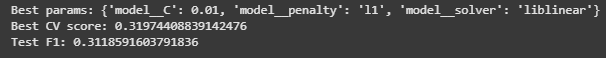